In [1]:
import camb
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

In [2]:
class CMBspectra:

    def __init__(self,lmax=1024,raw_cl=True):
        self.lmax = lmax
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.32,ombh2=0.02237,omch2=0.1201,mnu=0.06,tau=0.06)
        pars.InitPower.set_params(ns=0.9651,r=0)
        pars.set_for_lmax(lmax, lens_potential_accuracy=0)
        self.results = camb.get_results(pars)
        self.ell = np.arange(lmax+1)
        self.dl_TEB = (self.ell*(self.ell+1.))/ (2 * np.pi)
        self.dl_PP = (self.ell*(self.ell+1.))**2 / (2 * np.pi)
        self.dl_KK = (self.ell*(self.ell+1.))**2 / 4
        self.lensed_spectra = self.results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=raw_cl)[:self.lmax+1,:]
        self.unlensed_spectra = self.results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=raw_cl)[:self.lmax+1,:]
        self.lensing_spectra = self.results.get_lens_potential_cls(CMB_unit='muK', raw_cl=raw_cl)[:self.lmax+1,:]

    def plot(self,which='lensed'):
        if which == 'lensed':
            cls = self.lensed_spectra
            plt.loglog(np.arange(self.lmax+1),cls[:self.lmax+1,0],label='TT')
            plt.loglog(np.arange(self.lmax+1),cls[:self.lmax+1,1],label='EE')
            plt.loglog(np.arange(self.lmax+1),cls[:self.lmax+1,2],label='BB')
        elif which == 'unlensed':
            cls = self.unlensed_spectra
            plt.loglog(np.arange(self.lmax+1),cls[:self.lmax+1,0],label='TT')
            plt.loglog(np.arange(self.lmax+1),cls[:self.lmax+1,1],label='EE')
            plt.loglog(np.arange(self.lmax+1),cls[:self.lmax+1,2],label='BB')
        elif which == 'lensing':
            cls = self.lensing_spectra
            plt.loglog(np.arange(self.lmax+1),cls[:self.lmax+1,0],label='PP')
        else:
            raise ValueError('which must be "lensed" or "unlensed"')
        
        plt.legend()
        plt.xlim(2, self.lmax)

In [3]:
cmb = CMBspectra(lmax=3000)

In [32]:
N = 2**10  
pix_size  = 1.5
c_min = -400 
c_max = 400  
X_width = N*pix_size/60. 
Y_width = N*pix_size/60.

In [33]:
def cl2map(N,pix_size,ell,cl):
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) 
    X = np.outer(onesvec,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)

    pix_to_rad = (pix_size/60. * np.pi/180.)
    ell_scale_factor = 2. * np.pi /pix_to_rad
    ell2d = R * ell_scale_factor 
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 

    ClTT_expanded[0:(cl.size)] = cl


    CLTT2d = ClTT_expanded[ell2d.astype(int)] 

        

    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)  
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T 
    plt.imshow(np.real(FT_2d))
        

    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 

    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)

    CMB_T = np.real(CMB_T)

    return(CMB_T)

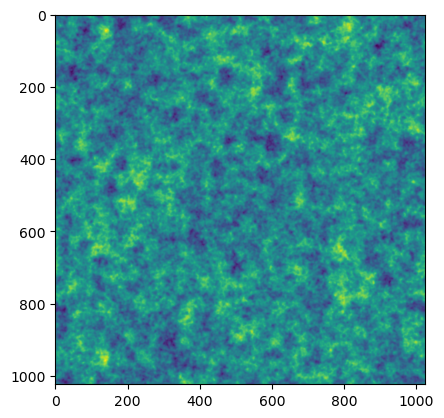

In [34]:
unlensed_t = cl2map(N,pix_size,cmb.ell,cmb.unlensed_spectra[:,0])
plt.imshow(unlensed_t)

In [35]:
unlensed_t.shape

(1024, 1024)

In [36]:
def map2cl(Map1,delta_ell,ell_max,pix_size,N,Map2=None):
    if Map2 is None:
        Map2 = Map1
    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))

    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        i = i + 1

    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

In [37]:
l, cl_tt = map2cl(unlensed_t,40,3000,pix_size,N)

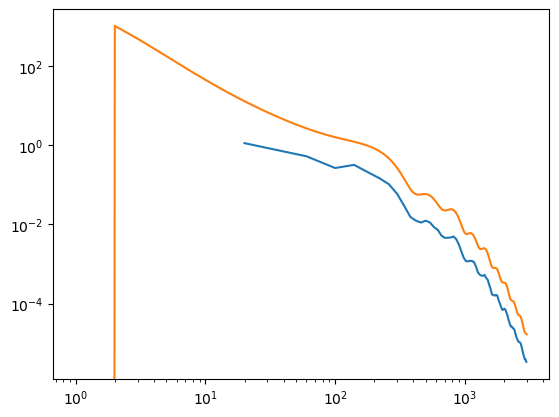

In [38]:
plt.loglog(l,cl_tt)
plt.loglog(cmb.ell,cmb.unlensed_spectra[:,0])

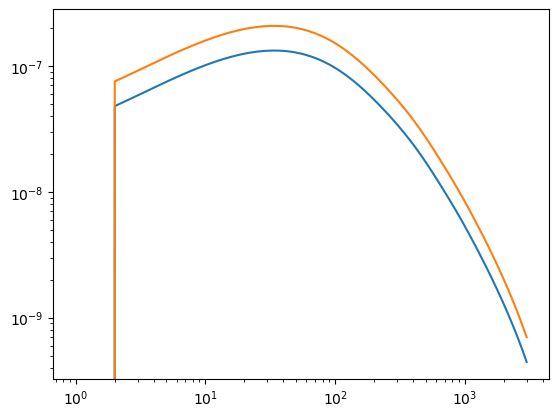

In [39]:
plt.loglog(cmb.ell,cmb.lensing_spectra[:,0]*cmb.dl_PP)
plt.loglog(cmb.ell,cmb.lensing_spectra[:,0]*cmb.dl_KK)

In [40]:
cl_KK = cmb.lensing_spectra[:,0]*cmb.dl_KK 

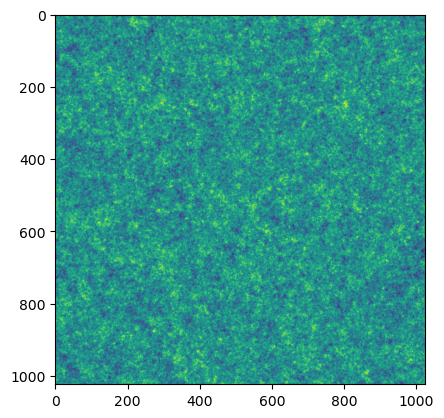

In [43]:
kappa = cl2map(N,pix_size,cmb.ell,cl_KK)
plt.imshow(kappa)

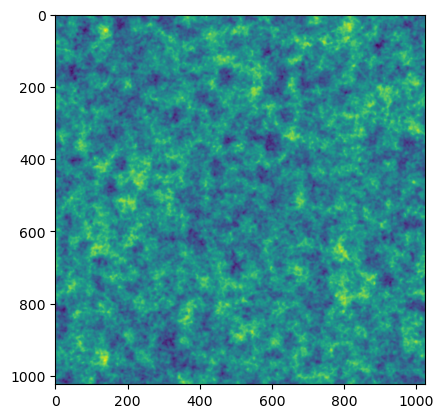

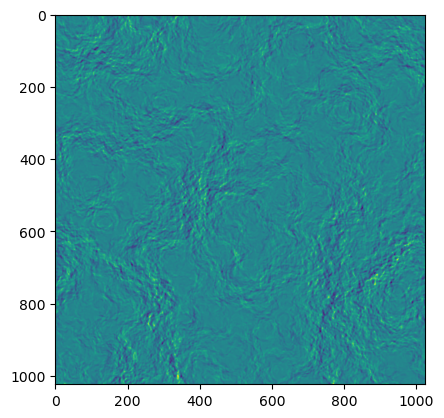

In [44]:
def lens_map(imap,kappa,modlmap,ly,lx,N,pix_size):
    # First we convert lensing convergence to lensing potential
    phi = kappa_to_phi(kappa,modlmap,return_fphi=True)
    # Then we take its gradient to get the deflection field
    grad_phi = gradient(phi,ly,lx)
    # Then we calculate the displaced positions by shifting the physical positions by the deflections
    pos = posmap(N,pix_size) + grad_phi
    # We convert the displaced positions into fractional displaced pixel numbers
    # because scipy doesn't know about physical distances
    pix = sky2pix(pos, N,pix_size)
    # We prepare an empty output lensed map array
    omap = np.empty(imap.shape, dtype= imap.dtype)
    # We then tell scipy to calculate the values of the input lensed map
    # at the displaced fractional positions by interpolation and grid that onto the final lensed map
    from scipy.ndimage import map_coordinates
    map_coordinates(imap, pix, omap, order=5, mode='wrap')
    return omap

# This function needs to know about the Fourier coordinates of the map
def get_ells(N,pix_size):
    # This function returns Fourier wavenumbers for a Cartesian square grid
    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    ell_scale_factor = 2. * np.pi 
    lx = np.outer(ones,inds) / (pix_size/60. * np.pi/180.) * ell_scale_factor
    ly = np.transpose(lx)
    modlmap = np.sqrt(lx**2. + ly**2.)
    return ly,lx,modlmap

# We need to convert kappa to phi
def kappa_to_phi(kappa,modlmap,return_fphi=False):
    return filter_map(kappa,kmask(2./modlmap/(modlmap+1.),modlmap,ellmin=2))

# where we used a Fourier space masking function which will come in handy
def kmask(filter2d,modlmap,ellmin=None,ellmax=None):
    # Apply a minimum and maximum multipole mask to a filter
    if ellmin is not None: filter2d[modlmap<ellmin] = 0
    if ellmax is not None: filter2d[modlmap>ellmax] = 0
    return filter2d

# To do that we also need to know generally how to filter a map
def filter_map(Map,filter2d):
    FMap = np.fft.fftshift(np.fft.fft2(Map))
    FMap_filtered = FMap * filter2d
    Map_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(FMap_filtered)))
    return Map_filtered


# We also need to calculate a gradient
# We do this in Fourier space
def gradient(imap,ly,lx):
    # Filter the map by (i ly, i lx) to get gradient
    return np.stack([filter_map(imap,ly*1j),filter_map(imap,lx*1j)])

# We also needed the map of physical positions
def posmap(N,pix_size):
    pix    = np.mgrid[:N,:N]
    return pix2sky(pix,N,pix_size)

# For that we need to be able to convert pixel indices to sky positions
def pix2sky(pix,N,pix_size):
    py,px = pix
    dec = np.deg2rad((py - N//2 - 0.5)*pix_size/60.)
    ra = np.deg2rad((px - N//2 - 0.5)*pix_size/60.)
    return np.stack([dec,ra])

# Finally, for the lensing operation, we also needed to convert physical sky positions to pixel indices
# which is just the inverse of the above
def sky2pix(pos,N,pix_size):
    dec,ra = np.rad2deg(pos)*60.
    py = dec/pix_size + N//2 + 0.5
    px = ra/pix_size + N//2 + 0.5
    return np.stack([py,px])

# We get the Fourier coordinates
ly,lx,modlmap = get_ells(N,pix_size)

# Now we can lens our input unlensed map
lensed = lens_map(unlensed_t,kappa,modlmap,ly,lx,N,pix_size)

plt.imshow(lensed)
plt.show()
plt.imshow(lensed-unlensed_t)
plt.show()

In [45]:
ell = cmb.ell

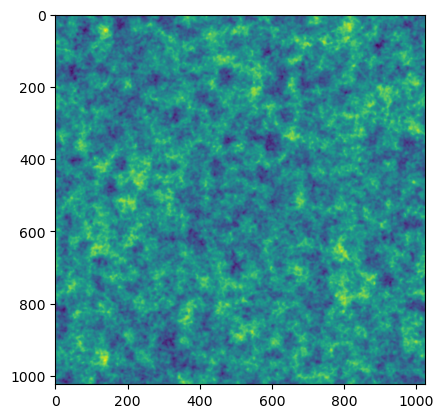

In [46]:
# Let's make this more like a real experiment by convolving with a beam and adding noise

# Beam
beam_arcmin = 1.4
def gauss_beam(ell,fwhm):
    # A gaussian beam transfer function (map-space, i.e. one power)
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))
# Evaluate the beam on an isotropic Fourier grid
kbeam2d = gauss_beam(modlmap,beam_arcmin)
# Filter the map to convolve it with a beam
beamed = filter_map(lensed,kbeam2d)

# Noise
noise_uk_arcmin = 1.5 # CMB-S4 level white noise
# White noise
Clnoise = (noise_uk_arcmin*np.pi/180./60.)**2.
Dlnoise = Clnoise*np.ones(ell.size)
# Make a GRF noise map
noise_map = cl2map(N,pix_size,ell,Dlnoise)

# The observed map
observed = beamed + noise_map

plt.imshow(observed)
plt.show()

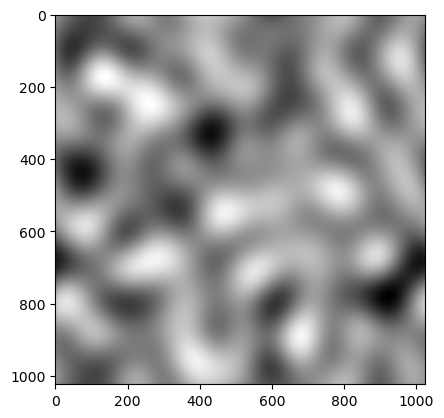

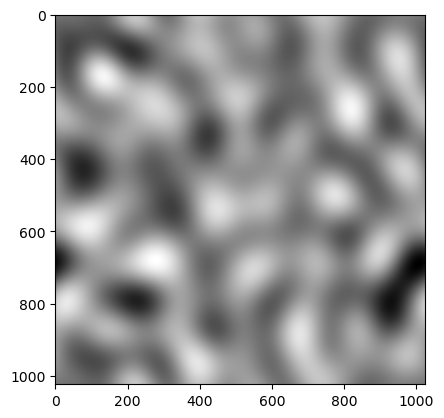

<Figure size 640x480 with 0 Axes>

In [47]:
# Now we attempt to reconstruct a lensing map from the observed map
def qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx):
    """
    The simplest form of the quadratic estimator is

    kappa_recon = - div ( grad(T) T )
    where grad(T) is Wiener filtered with (unlensed_cmb_power/total_cmb_power)
    and T is filtered with (1/total_cmb_power)
    where the T map is beam deconvolved and
    where total_cmb_power = lensed_cmb_power + noise_power / beam^2

    The reconstruction is limited to ellmin < ells < ellmax of the CMB temperature map.

    The grad and div operations require knowledge of:
    modlmap: absolute wavenumbers of Fourier pixels
    ly: map of ly Fourier coordinate of each pixel
    lx: map of lx Fourier coordinate of each pixel
    (note modlmap = sqrt(ly**2 + lx**2)
    """
    inv_noise_filter = kmask((1./total_cmb_power_2d),modlmap,ellmin,ellmax)
    grad_filter = kmask((unlensed_cmb_power_2d/total_cmb_power_2d),modlmap,ellmin,ellmax)

    gradTy,gradTx = gradient(tmap,ly,lx)

    filtered_gradTy = filter_map(gradTy,grad_filter)
    filtered_gradTx = filter_map(gradTx,grad_filter)
    filtered_T = filter_map(tmap,inv_noise_filter)
    
    ukappa = div(filtered_T * filtered_gradTy, filtered_T * filtered_gradTx, ly, lx)

    # We filter with 1/L^2 at the end to make the normalization white
    return -filter_map(ukappa,kmask(1/modlmap**2,modlmap,ellmin=2))

# For this we also need to know how to calculate a divergence
def div(imapy,imapx,ly,lx):
    # Return divergence grad(Y)_y + grad(X)_x
    gy = gradient(imapy,ly,lx)
    gx = gradient(imapx,ly,lx)
    return gy[0] + gx[1]


def interp(x,y,bounds_error=False,fill_value=0.,**kwargs):
    # Just a simple interpolator that fills with zeros by default
    from scipy.interpolate import interp1d
    return interp1d(x,y,bounds_error=bounds_error,fill_value=fill_value,**kwargs)


# To use this we need unlensed and total spectra interpolated on to the 2D Fourier grid
### Prepare 2D Fourier space interpolations of theory spectra
unlensed_cmb_power_2d = interp(ell,cmb.unlensed_spectra[:,0])(modlmap)
total_cmb_power_2d = interp(ell,cmb.lensed_spectra[:,0])(modlmap) + Clnoise/kbeam2d**2.


### The noise was specified for a beam deconvolved map so we deconvolve the beam from our map
tmap = filter_map(observed,1/kbeam2d)

### Next, we get the unnormalized reconstruction after choosing what multipoles to involve
ellmin = 10
ellmax = 3000
ukappa = qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx)

# Calculating the normalization is a bit involved, so for now we focus on comparing
# the largest scales of the reconstruction with that of the input, where the normalization is
# expected to be somewhat constant

### Filter the reconstruction and the input kappa to the same ellrange (where the normalization
### is expected to be relatively white)
kellmin = 10
kellmax = 100
ukappa_f = filter_map(ukappa,kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))
ikappa_f = filter_map(kappa,kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))

# Plot the filtered maps for comparison
plt.imshow(ukappa_f,cmap='gray')
plt.show()
plt.clf()
plt.imshow(ikappa_f,cmap='gray')
plt.show()
plt.clf()